In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import wavfile

In [2]:
base_dir = 'Prediction/For_Analysis'
classes = {
    'Healthy_Female': 0,
    'Healthy_Male': 1,
    'PD_Female': 2,
    'PD_Male': 3
}

In [3]:
def compute_jitter(signal, fs):
    crossings = np.where(np.diff(np.signbit(signal)))[0]
    if len(crossings) < 2:
        return 0.0
    periods = np.diff(crossings) / fs
    if len(periods) < 2 or np.mean(periods) == 0:
        return 0.0
    jitter = np.sum(np.abs(np.diff(periods))) / ((len(periods) - 1) * np.mean(periods))
    return jitter

In [4]:
def compute_shimmer(signal):
    peaks = signal[signal > np.mean(signal)]
    if len(peaks) < 2 or np.mean(peaks) == 0:
        return 0.0
    shimmer = np.mean(np.abs(np.diff(peaks))) / np.mean(peaks)
    return shimmer

In [5]:
from scipy.io import wavfile
fs_healthy, signal_healthy = wavfile.read("/Users/manyasharma/Prediction/For_Analysis/Healthy_Male/Healthy_Male_a_18.wav")
fs_parkinsons, signal_parkinsons = wavfile.read("/Users/manyasharma/Prediction/For_Analysis/PD_Male/PD_Male_a_18.wav")

if signal_healthy.dtype == 'int16':
    signal_healthy = signal_healthy / 32768.0
if signal_parkinsons.dtype == 'int16':
    signal_parkinsons = signal_parkinsons / 32768.0

In [6]:
jitter_healthy = compute_jitter(signal_healthy, fs_healthy)
jitter_parkinsons = compute_jitter(signal_parkinsons, fs_parkinsons)

shimmer_healthy = compute_shimmer(signal_healthy)
shimmer_parkinsons = compute_shimmer(signal_parkinsons)

In [7]:
print("Jitter (Healthy):", jitter_healthy)
print("Jitter (Parkinson):", jitter_parkinsons)
print("Shimmer (Healthy):", shimmer_healthy)
print("Shimmer (Parkinson):", shimmer_parkinsons)

Jitter (Healthy): 1.2421812355141222
Jitter (Parkinson): 1.2876063169796395
Shimmer (Healthy): 0.15102664197011398
Shimmer (Parkinson): 0.15675087701599796


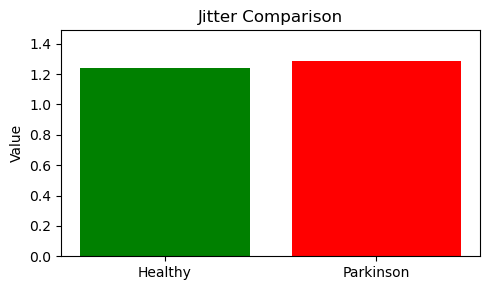

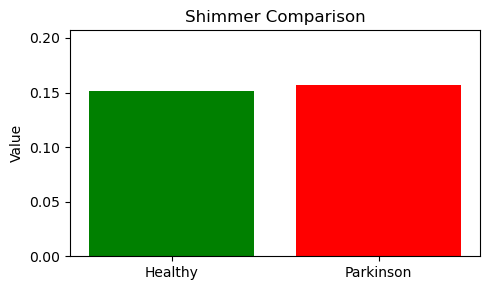

In [8]:
import matplotlib.pyplot as plt

jitter_vals = [1.242, 1.288]
shimmer_vals = [0.151, 0.157]
labels = ['Healthy', 'Parkinson']

plt.figure(figsize=(5, 3))
plt.bar(labels, jitter_vals, color=['green', 'red'])
plt.title("Jitter Comparison")
plt.ylabel("Value")
plt.ylim(0, max(jitter_vals) + 0.2)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 3))
plt.bar(labels, shimmer_vals, color=['green', 'red'])
plt.title("Shimmer Comparison")
plt.ylabel("Value")
plt.ylim(0, max(shimmer_vals) + 0.05)
plt.tight_layout()
plt.show()

In [9]:
def compute_lpc(signal, order=12):
    autocorr = np.correlate(signal, signal, mode='full')[len(signal)-1:]
    R = autocorr[:order+1]
    if R[0] == 0:
        return np.zeros(order)
    
    A = np.zeros(order)
    E = R[0]

    for i in range(order):
        acc = sum([A[j] * R[i - j] for j in range(i)])
        k = (R[i + 1] - acc) / E
        A_new = A.copy()
        A_new[i] = k
        for j in range(i):
            A_new[j] = A[j] - k * A[i - j - 1]
        A = A_new
        E = E * (1 - k**2)
    
    return A

In [10]:
def compute_snr(signal):
    noise = signal[-1000:]  
    signal_power = np.mean(signal**2)
    noise_power = np.mean(noise**2) if np.mean(noise**2) != 0 else 1e-6
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

In [11]:
def compute_hnr(signal):
    autocorr = np.correlate(signal, signal, mode='full')
    autocorr = autocorr[len(autocorr)//2:]

    if np.max(autocorr[1:]) == 0 or autocorr[0] == 0:
        return 0

    hnr = 10 * np.log10(np.max(autocorr[1:]) / (autocorr[0] - np.max(autocorr[1:])))
    return hnr

In [12]:
import os
import pandas as pd
from scipy.io import wavfile

def process_all_snr_hnr(folder_path):
    data = []

    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if not os.path.isdir(label_path):
            continue

        for file in os.listdir(label_path):
            if file.endswith(".wav"):
                file_path = os.path.join(label_path, file)
                fs, signal = wavfile.read(file_path)
                signal = signal.astype(float)
                signal /= np.max(np.abs(signal)) 

                snr = compute_snr(signal)
                hnr = compute_hnr(signal)

                data.append({
                    "Filename": file,
                    "Label": label,
                    "SNR": snr,
                    "HNR": hnr
                })

    return pd.DataFrame(data)

In [13]:
fs, signal = wavfile.read("Prediction/For_Analysis/Healthy_Female/Healthy_Female_a_10.wav")
signal = signal.astype(float)
signal /= np.max(np.abs(signal)) 

snr_value = compute_snr(signal)
hnr_value = compute_hnr(signal)

print(f"SNR: {snr_value:.2f} dB")
print(f"HNR: {hnr_value:.2f} dB")

SNR: -0.04 dB
HNR: 18.34 dB


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_snr_hnr_heatmap(df, feature_name):
    df_sorted = df.sort_values(by="Label")
    feature_matrix = df_sorted[[feature_name]].T

    plt.figure(figsize=(12, 2))
    sns.heatmap(feature_matrix, cmap='coolwarm', cbar=True,
                xticklabels=False, yticklabels=[feature_name])
    plt.title(f"{feature_name} Heatmap across Samples")
    plt.tight_layout()
    plt.show()

In [15]:
def compute_lpcc(lpc, order=12):
    lpcc = np.zeros(order)
    lpcc[0] = -np.log(lpc[0]) if lpc[0] != 0 else 0

    for n in range(1, order):
        acc = 0
        for k in range(n):
            acc += ((n - k) / n) * lpcc[k] * lpc[n - k - 1]
        lpcc[n] = lpc[n - 1] + acc if n < len(lpc) else acc
    return lpcc

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from scipy.fftpack import dct

def erb_scale(f):
    return 24.7 * (4.37e-3 * f + 1)

def make_gammatone_filterbank(fs, num_filters=13, nfft=512):
    low_freq = 100
    high_freq = fs / 2
    center_freqs = np.logspace(np.log10(low_freq), np.log10(high_freq), num_filters)
    erb_bandwidths = erb_scale(center_freqs)
    return center_freqs, erb_bandwidths

def apply_gammatone_filterbank(frame, fs, num_filters=13, nfft=512):
    center_freqs, erb_bandwidths = make_gammatone_filterbank(fs, num_filters, nfft)
    power_spectrum = np.abs(np.fft.rfft(frame, n=nfft)) ** 2
    freqs = np.fft.rfftfreq(nfft, d=1/fs)

    filterbank_output = np.zeros((num_filters,))
    for i in range(num_filters):
        f0 = center_freqs[i]
        bw = erb_bandwidths[i]
        gammatone_filter = 1.0 / (1.0 + ((freqs - f0) / (bw / 2)) ** 2)
        filterbank_output[i] = np.sum(power_spectrum * gammatone_filter)

    gfcc = dct(np.log(filterbank_output + 1e-6), type=2, norm='ortho')
    return gfcc[:13]  

In [17]:
fs, signal = wav.read("/Users/manyasharma/Prediction/For_Analysis/PD_Male/PD_Male_a_18.wav")  
signal = signal / np.max(np.abs(signal))  

frame_size = 0.025  # 25 ms
frame_stride = 0.01  # 10 ms
frame_len = int(fs * frame_size)
frame_step = int(fs * frame_stride)
signal_length = len(signal)
num_frames = int(np.ceil((signal_length - frame_len) / frame_step)) + 1

pad_signal_len = num_frames * frame_step + frame_len
pad_signal = np.append(signal, np.zeros(pad_signal_len - signal_length))

frames = np.zeros((num_frames, frame_len))
for i in range(num_frames):
    start = i * frame_step
    frames[i] = pad_signal[start:start + frame_len]

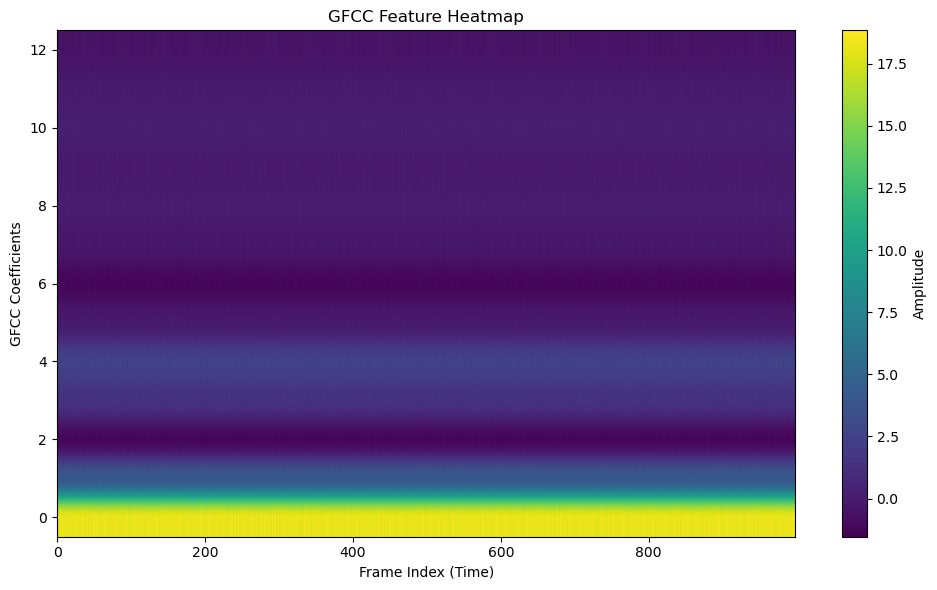

In [18]:
gfcc_features = np.array([apply_gammatone_filterbank(frame * np.hamming(frame_len), fs) for frame in frames])
plt.figure(figsize=(10, 6))
plt.imshow(gfcc_features.T, aspect='auto', origin='lower', cmap='viridis')
plt.title('GFCC Feature Heatmap')
plt.xlabel('Frame Index (Time)')
plt.ylabel('GFCC Coefficients')
plt.colorbar(label='Amplitude')
plt.tight_layout()
plt.show()

In [19]:
fs, signal = wav.read("/Users/manyasharma/Prediction/For_Analysis/Healthy_Male/Healthy_Male_a_18.wav")  
signal = signal / np.max(np.abs(signal))  

frame_size = 0.025
frame_stride = 0.01  
frame_len = int(fs * frame_size)
frame_step = int(fs * frame_stride)
signal_length = len(signal)
num_frames = int(np.ceil((signal_length - frame_len) / frame_step)) + 1

pad_signal_len = num_frames * frame_step + frame_len
pad_signal = np.append(signal, np.zeros(pad_signal_len - signal_length))

frames = np.zeros((num_frames, frame_len))
for i in range(num_frames):
    start = i * frame_step
    frames[i] = pad_signal[start:start + frame_len]

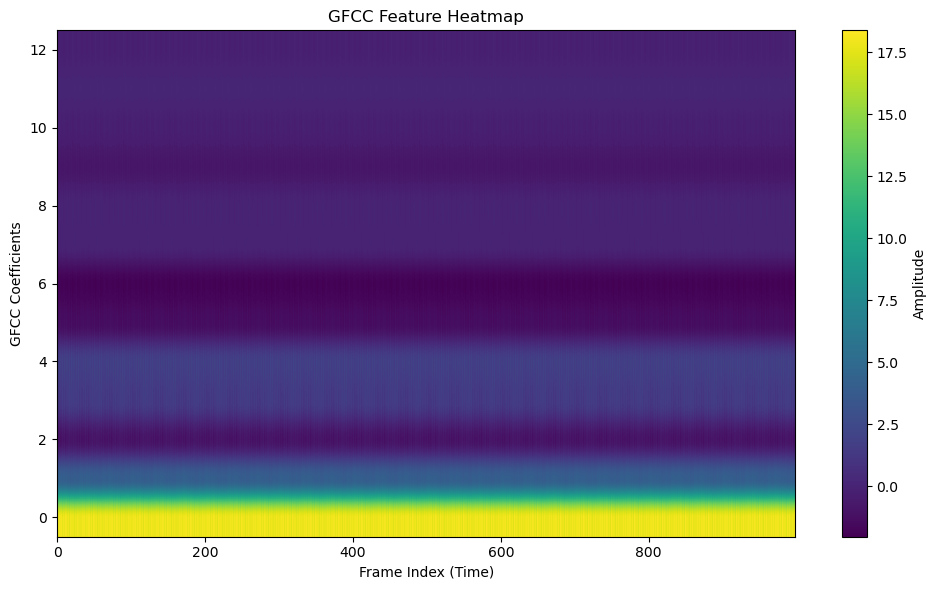

In [20]:
gfcc_features = np.array([apply_gammatone_filterbank(frame * np.hamming(frame_len), fs) for frame in frames])
plt.figure(figsize=(10, 6))
plt.imshow(gfcc_features.T, aspect='auto', origin='lower', cmap='viridis')
plt.title('GFCC Feature Heatmap')
plt.xlabel('Frame Index (Time)')
plt.ylabel('GFCC Coefficients')
plt.colorbar(label='Amplitude')
plt.tight_layout()
plt.show()

In [21]:
def extract_features(file_path):
    fs, signal = wavfile.read(file_path)
    signal = signal.astype(float)
    if np.max(np.abs(signal)) != 0:
        signal /= np.max(np.abs(signal))

    if len(signal) > fs:
        signal = signal[int(0.25*fs):int(0.75*fs)]

    jitter = compute_jitter(signal, fs)
    shimmer = compute_shimmer(signal)
    lpc = compute_lpc(signal)
    lpcc = compute_lpcc(lpc)
    snr = compute_snr(signal)
    hnr = compute_hnr(signal)
    gfcc = apply_gammatone_filterbank(signal, fs)

    frame_size = int(0.025 * fs)
    stride = int(0.01 * fs)
    energies = [np.sum(signal[i:i+frame_size]**2) 
                for i in range(0, len(signal) - frame_size, stride)]
    energy_mean = np.mean(energies) if energies else 0
    energy_std = np.std(energies) if energies else 0

    return [jitter, shimmer, snr, hnr, energy_mean, energy_std] + list(lpc) + list(lpcc) + list(gfcc)

In [22]:
import pandas as pd
from scipy.io import wavfile

base_dir = "Prediction/For_Analysis"
classes = {
    "Healthy_Female": 0,
    "Healthy_Male": 1,
    "PD_Female": 2,
    "PD_Male": 3
}

X = []
y = []

for class_name, label in classes.items():
    folder_path = os.path.join(base_dir,class_name)
    for file in os.listdir(folder_path):
        if file.endswith('.wav'):
            file_path = os.path.join(folder_path, file)
            try:
                features = extract_features(file_path)
                X.append(features)
                y.append(label)
            except Exception as e:
                print(f"Error in {file_path}: {e}")

In [23]:
columns = ['Jitter', 'Shimmer', 'SNR', 'HNR', 'Energy_Mean', 'Energy_Std'] + \
          [f'LPC_{i+1}' for i in range(12)] + \
          [f'LPCC_{i+1}' for i in range(12)] + \
          [f'GFCC_{i+1}' for i in range(13)] + ['Label']

In [24]:
!pip install python_speech_features
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc

In [25]:
def plot_feature_heatmap(feature_matrix, title, ylabel="Coefficient Index"):
    plt.figure(figsize=(12, 4))
    plt.imshow(feature_matrix.T, aspect='auto', origin='lower', cmap='viridis')
    plt.title(title)
    plt.xlabel("Frames")
    plt.ylabel(ylabel)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

In [26]:
def extract_mfcc(signal, fs):
    return mfcc(signal, samplerate=fs, numcep=13, nfilt=26)

In [27]:
from scipy.signal import lfilter
from scipy.linalg import solve_toeplitz

def frame_signal(signal, frame_size, frame_stride, sample_rate):
    frame_len = int(round(frame_size * sample_rate))
    frame_step = int(round(frame_stride * sample_rate))
    signal_len = len(signal)
    num_frames = int(np.ceil(float(np.abs(signal_len - frame_len)) / frame_step)) + 1

    pad_len = num_frames * frame_step + frame_len
    z = np.zeros((pad_len - signal_len))
    pad_signal = np.append(signal, z)

    indices = np.tile(np.arange(0, frame_len), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_len, 1)).T
    return pad_signal[indices.astype(np.int32, copy=False)]

def extract_lpc(signal, fs, order=12):
    frames = frame_signal(signal, frame_size=0.025, frame_stride=0.01, sample_rate=fs)
    lpc_matrix = []
    for frame in frames:
        autocorr = np.correlate(frame, frame, mode='full')[len(frame)-1:]
        r = autocorr[:order+1]
        if r[0] == 0: continue
        a = solve_toeplitz((r[:-1], r[:-1]), r[1:])
        lpc_matrix.append(a)
    return np.array(lpc_matrix)

In [28]:
def extract_lpcc(lpc_coeffs, order=12):
    N = lpc_coeffs.shape[0]
    lpcc_matrix = np.zeros((N, order))
    for i in range(N):
        a = np.concatenate(([1], -lpc_coeffs[i]))
        lpcc = np.zeros(order)
        lpcc[0] = -a[1]
        for n in range(1, order):
            acc = 0
            for k in range(1, n):
                acc += (k / n) * lpcc[k] * a[n - k]
            lpcc[n] = -a[n + 1] - acc if n + 1 < len(a) else -acc
        lpcc_matrix[i] = lpcc
    return lpcc_matrix

In [29]:
def process_and_plot(wav_path):
    fs, signal = wavfile.read(wav_path)
    signal = signal.astype(float)
    signal = signal / np.max(np.abs(signal))

    mfcc_feat = extract_mfcc(signal, fs)
    lpc_feat = extract_lpc(signal, fs)
    lpcc_feat = extract_lpcc(lpc_feat)

    plot_feature_heatmap(mfcc_feat, "MFCC Heatmap")
    plot_feature_heatmap(lpc_feat, "LPC Heatmap")
    plot_feature_heatmap(lpcc_feat, "LPCC Heatmap")

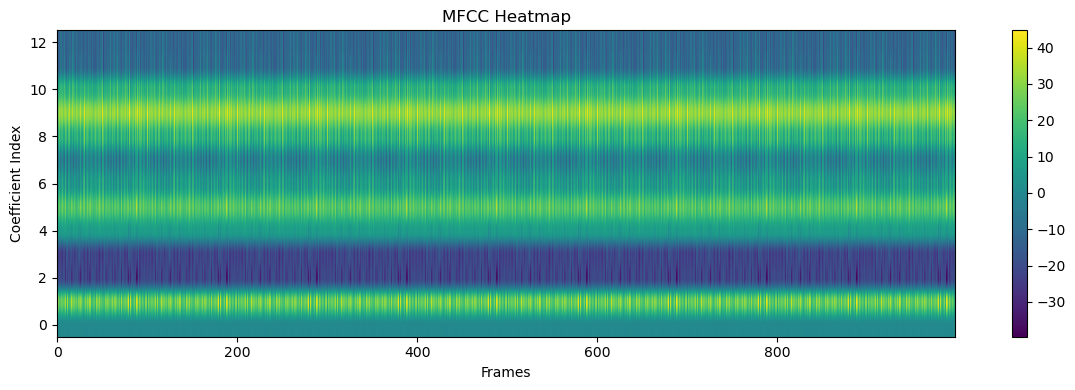

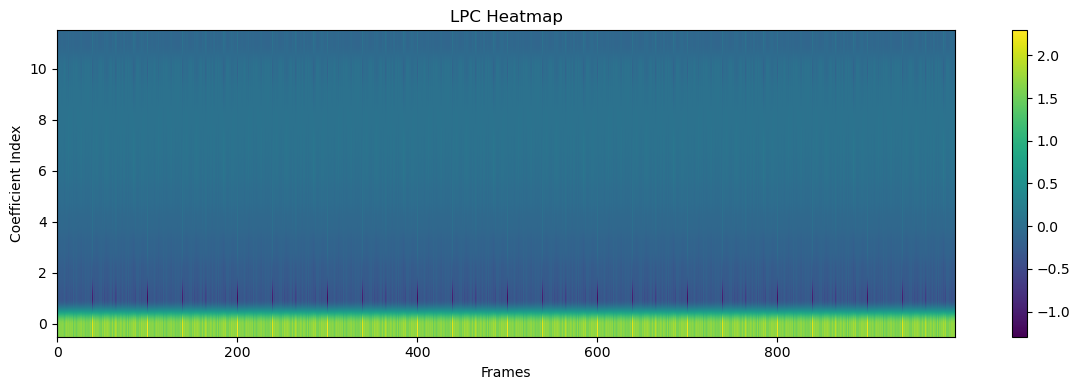

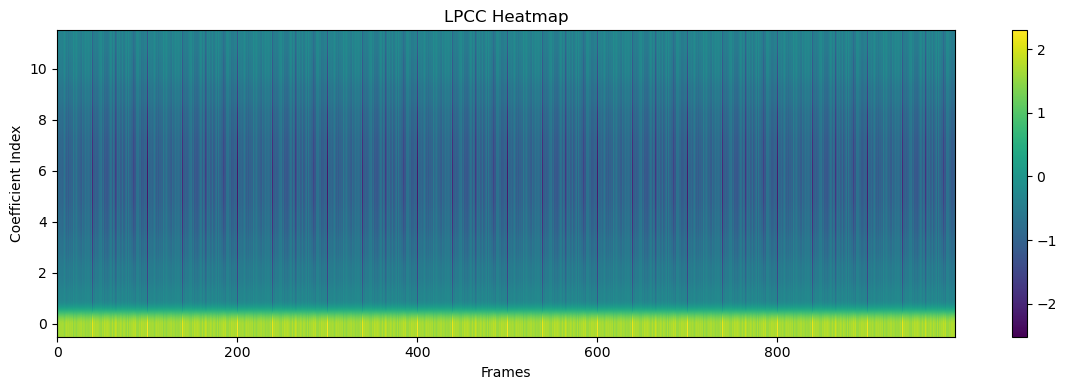

In [30]:
process_and_plot("/Users/manyasharma/Prediction/For_Analysis/PD_Male/PD_Male_a_18.wav") 

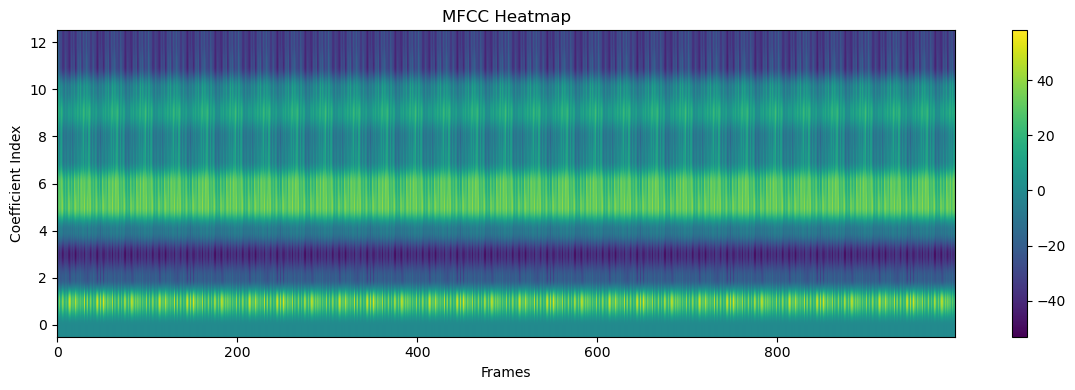

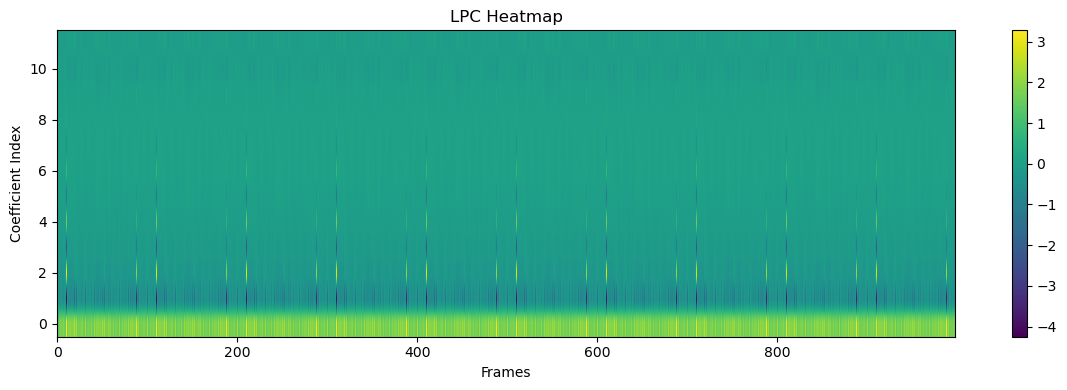

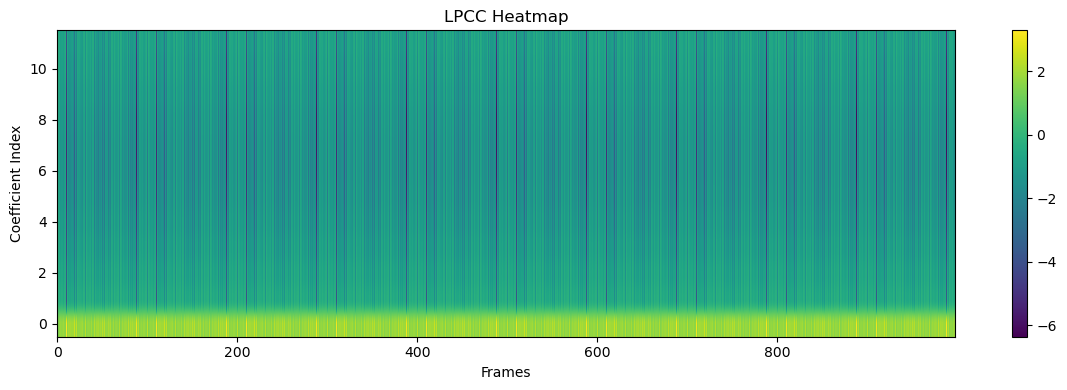

In [31]:
process_and_plot("/Users/manyasharma/Prediction/For_Analysis/Healthy_Male/Healthy_Male_a_18.wav")

In [32]:
def plot_one_from_each_class(base_dir="Prediction/For_Analysis"):
    colors = {
        "Healthy_Female": "steelblue",
        "Healthy_Male": "blue",
        "PD_Female": "grey",
        "PD_Male": "lightblue"
    }

    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                if file.endswith(".wav"):
                    fs, sig = wavfile.read(os.path.join(class_path, file))
                    color = colors.get(class_name, 'purple')
                    title = f"{class_name.replace('_', ' ')} Voice Waveform"
                    plot_waveform(sig, fs, title=title, color=color)
                    break  

In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def plot_waveform(signal_data, sample_rate, title="Voice Waveform", color='blue'):
    if signal_data.ndim > 1:
        signal_data = np.mean(signal_data, axis=1)

    signal_data = signal_data / np.max(np.abs(signal_data))

    time_axis = np.linspace(0, len(signal_data) / sample_rate, num=len(signal_data))

    plt.figure(figsize=(12, 4))
    plt.plot(time_axis, signal_data, color=color)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Normalized Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

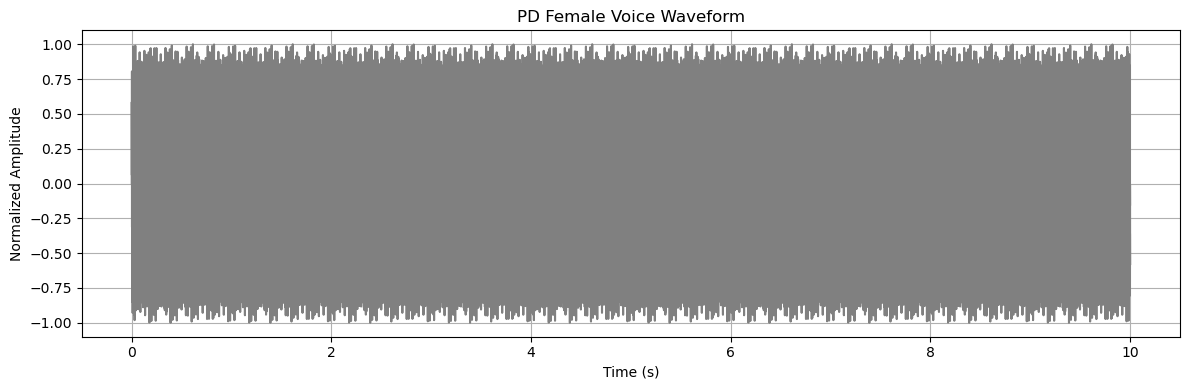

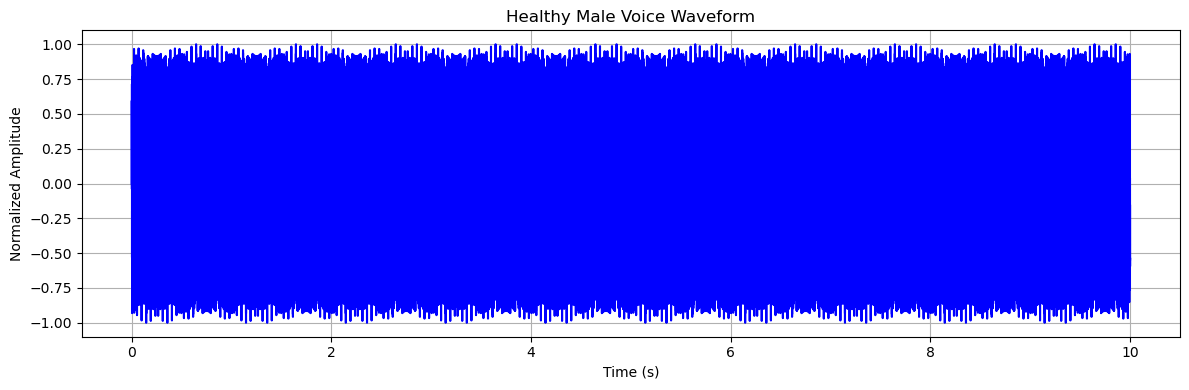

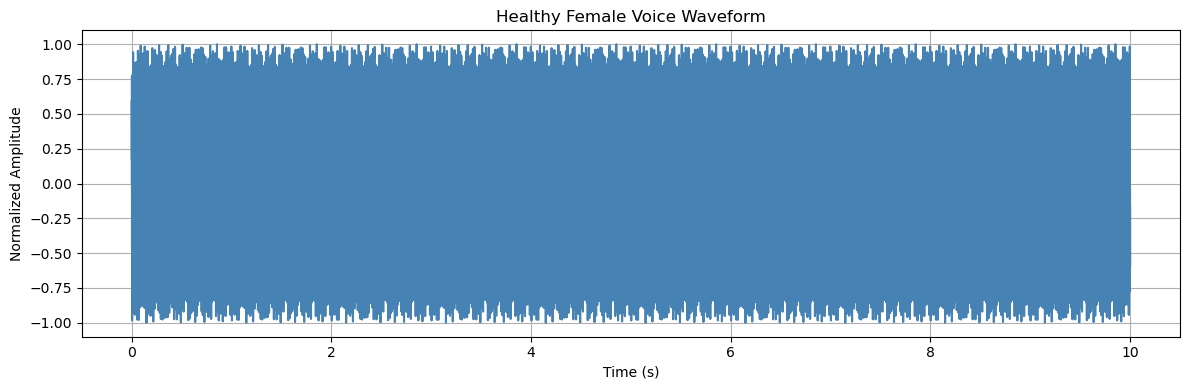

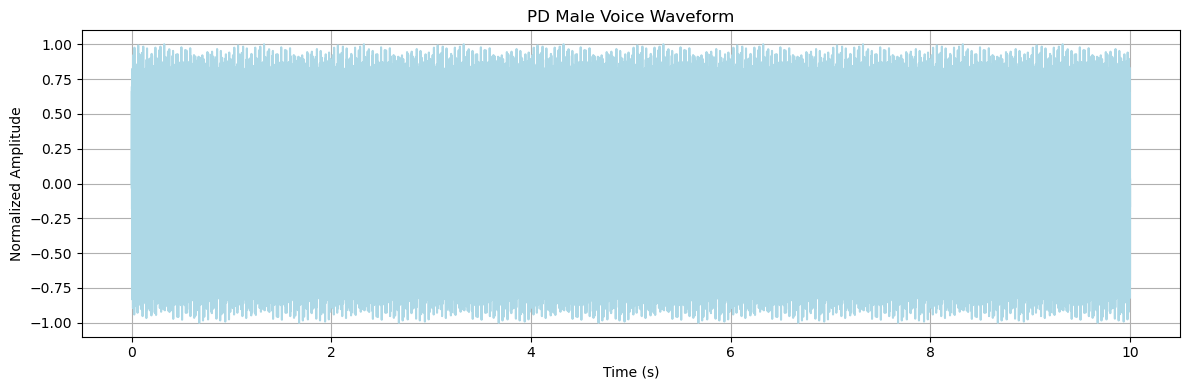

In [35]:
plot_one_from_each_class(base_dir="Prediction/For_Analysis")

In [36]:
print("Max amplitude:", np.max(signal))
print("Min amplitude:", np.min(signal))
print("Mean:", np.mean(signal))

Max amplitude: 0.999969481490524
Min amplitude: -1.0
Mean: -6.920296975223909e-11


Original dtype: int16
Signal shape: (441000,)
Max amplitude: 32766
Min amplitude: -32767
Mean amplitude: -2.2675736961451247e-06


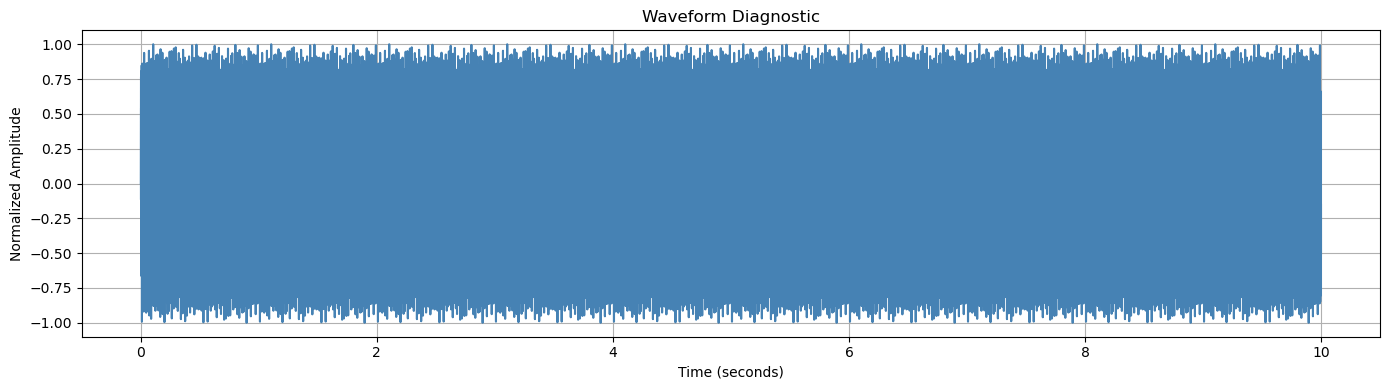

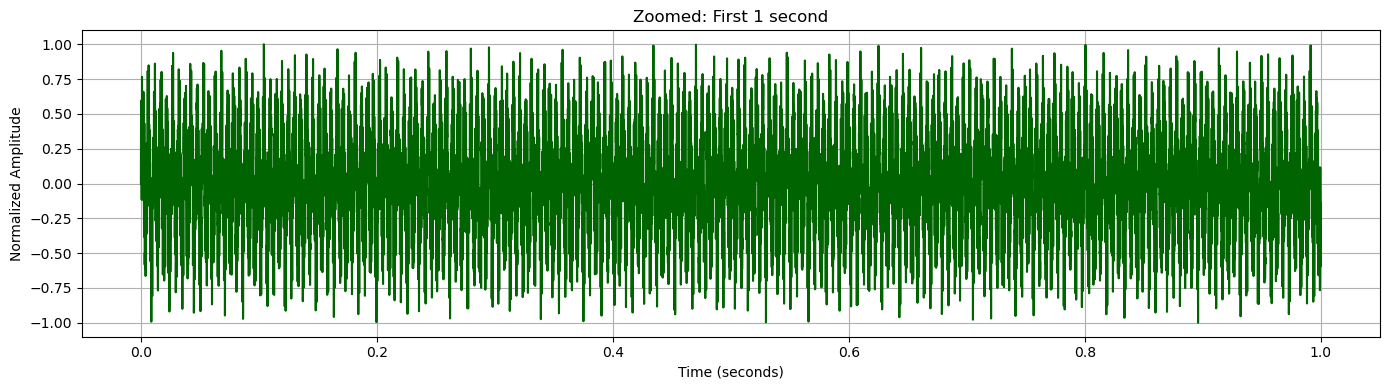

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

def plot_waveform_diagnostic(filepath):
    fs, signal = wavfile.read(filepath)
    print("Original dtype:", signal.dtype)
    print("Signal shape:", signal.shape)
    print("Max amplitude:", np.max(signal))
    print("Min amplitude:", np.min(signal))
    print("Mean amplitude:", np.mean(signal))

    if len(signal.shape) == 2:
        signal = np.mean(signal, axis=1)

    if signal.dtype == np.int16:
        signal = signal.astype(np.float32)
        signal /= 32768.0

    time_axis = np.linspace(0, len(signal) / fs, num=len(signal))
    plt.figure(figsize=(14, 4))
    plt.plot(time_axis, signal, color='steelblue')
    plt.title("Waveform Diagnostic")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Normalized Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 4))
    zoomed = signal[:fs] 
    zoom_time = np.linspace(0, 1, num=len(zoomed))
    plt.plot(zoom_time, zoomed, color='darkgreen')
    plt.title("Zoomed: First 1 second")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Normalized Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_waveform_diagnostic("Prediction/For_Analysis/Healthy_Female/Healthy_Female_a_18.wav")

Original dtype: int16
Signal shape: (441000,)
Max amplitude: 32766
Min amplitude: -32767
Mean amplitude: -2.2675736961451247e-06


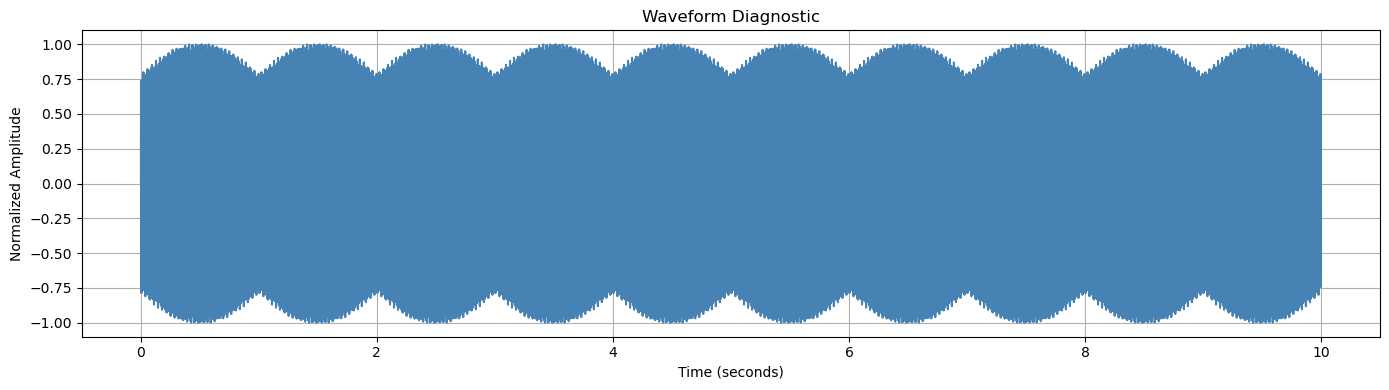

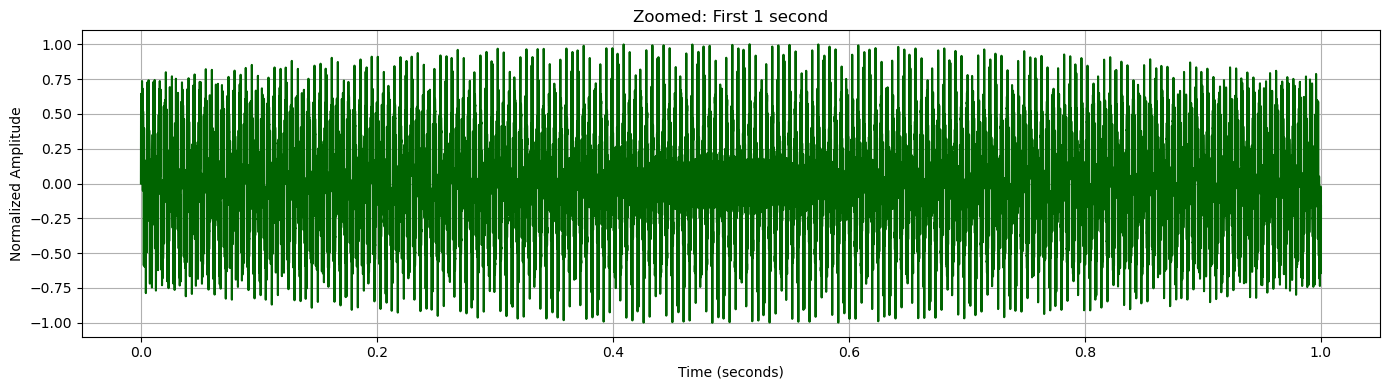

In [38]:
plot_waveform_diagnostic("Prediction/For_Analysis/PD_Female/PD_Female_a_18.wav")

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [40]:
import pandas as pd
df = pd.read_csv('parkinsons_binary.csv')

X = df.drop(columns=['binary_label'])
y = df['binary_label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

model = SVC(kernel='rbf', C=1, gamma='scale')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 9 11]
 [ 3 17]]
              precision    recall  f1-score   support

           0       0.75      0.45      0.56        20
           1       0.61      0.85      0.71        20

    accuracy                           0.65        40
   macro avg       0.68      0.65      0.64        40
weighted avg       0.68      0.65      0.64        40



In [42]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.001],
    'kernel': ['rbf', 'poly']
}

grid = GridSearchCV(SVC(), param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

Best Parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Best Score: 0.63125


In [43]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.69      0.55      0.61        20
           1       0.62      0.75      0.68        20

    accuracy                           0.65        40
   macro avg       0.66      0.65      0.65        40
weighted avg       0.66      0.65      0.65        40



In [44]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
print("Accuracy:", model.score(X_test, y_test))

Accuracy: 0.675


In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10, 100, 150, 200, 300, 500, 1000],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear']
}

grid = GridSearchCV(SVC(), param_grid, cv=5) 
grid.fit(X_train, y_train)

best_params = grid.best_params_
best_score = grid.best_score_

print(f" Best Kernel: {best_params['kernel']}")
print(f" Best C: {best_params['C']}")
print(f" Best Gamma: {best_params['gamma']}")
print(f" Best Accuracy: {best_score:.4f}")

 Best Kernel: rbf
 Best C: 100
 Best Gamma: 0.001
 Best Accuracy: 0.6312


In [46]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

df = pd.read_csv('parkinsons_binary.csv')  

X = df.drop('binary_label', axis=1)
y = df['binary_label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

svm_model = SVC(C=100, gamma=0.001, kernel='rbf')
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Confusion Matrix:
 [[10 10]
 [ 5 15]]

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.50      0.57        20
           1       0.60      0.75      0.67        20

    accuracy                           0.62        40
   macro avg       0.63      0.62      0.62        40
weighted avg       0.63      0.62      0.62        40

Accuracy Score: 0.625


In [47]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

df = pd.read_csv('parkinsons_binary.csv')  

X = df.drop('binary_label', axis=1)
y = df['binary_label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

svm_model = SVC(C=10, gamma='auto', kernel='rbf')
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Confusion Matrix:
 [[12  8]
 [ 4 16]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67        20
           1       0.67      0.80      0.73        20

    accuracy                           0.70        40
   macro avg       0.71      0.70      0.70        40
weighted avg       0.71      0.70      0.70        40

Accuracy Score: 0.7


In [48]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [50]:
import joblib

joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("Model and scaler saved successfully!")

Model and scaler saved successfully!
